<a href="https://colab.research.google.com/github/DamienGulliver/Institute_of_data/blob/main/capstone_preprocess.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
# Install packages into colab environment

!pip install iterative-stratification
!pip install category_encoders

In [6]:
# Import packages

import os
import sys
import time
import random
import math
from tqdm import tqdm
from sklearn.manifold import TSNE
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import train_test_split
import tensorflow as tf
import pandas as pd
import numpy as np
np.set_printoptions(threshold=sys.maxsize)
import seaborn as sns
sns.set(style="darkgrid")
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
%matplotlib inline
import category_encoders as ce
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from google.cloud import storage

In [7]:
# Define environment variables

PROJECT_ID = 'effnet-moa'
BUCKET_NAME = 'effnet-moa'
DATA_DIR = 'gs://effnet-moa'
DATA_SAVE_PATH = 'capstone_preprocessed_data/res300_batchsize_256/'
RAND_SEED = 42
PERPLEXITY = 5 # TSNE hyperparameter optimised to yield the highest variance between image matrices
RESOLUTION = 300 # image input size for efficientnetB3
CHANNELS = 3 # Keep RGB color channels to match the input format of the model
BATCH_SIZE = 256 # size to store data as TFRecord files on GCS (matches batch size for model. Minimum 256 for effective TPU utilisation)

In [8]:
# Set up google credentials to access GCS bucket

from google.colab import auth
auth.authenticate_user()

!gcloud config set project {PROJECT_ID}
!gsutil ls

Updated property [core/project].
gs://effnet-moa/


In [9]:
# Copy raw data from GCS bucket

!gsutil cp gs://{BUCKET_NAME}/capstone_raw_data/lish-moa.zip /content/lish-moa.zip

Copying gs://effnet-moa/capstone_raw_data/lish-moa.zip...
| [1 files][ 64.7 MiB/ 64.7 MiB]                                                
Operation completed over 1 objects/64.7 MiB.                                     


In [10]:
# Unzip raw data

!unzip "/content/lish-moa.zip" -d "/content/"

Archive:  /content/lish-moa.zip
  inflating: /content/sample_submission.csv  
  inflating: /content/test_features.csv  
  inflating: /content/train_drug.csv  
  inflating: /content/train_features.csv  
  inflating: /content/train_targets_nonscored.csv  
  inflating: /content/train_targets_scored.csv  


In [11]:
# Read csv files into dataframes

features = pd.read_csv('/content/train_features.csv', engine='c')

labels = pd.read_csv('/content/train_targets_scored.csv', engine='c')

drugs = pd.read_csv('/content/train_drug.csv', engine='c')

features.shape, labels.shape, drugs.shape

((23814, 876), (23814, 207), (23814, 2))

In [12]:
# Sort frames by sig_id to ensure that all row orders match

features = features.sort_values(by=["sig_id"], axis=0, inplace=False).reset_index(drop=True)

labels = labels.sort_values(by=["sig_id"], axis=0, inplace=False).reset_index(drop=True)

drugs = drugs.sort_values(by=["sig_id"], axis=0, inplace=False).reset_index(drop=True)

for df in [features, labels, drugs]:
  df.set_index('sig_id', inplace=True)

In [13]:
# merge target classes and drug identifiers into single dataframe

labels = labels.join(drugs)

In [14]:
# Create new column for control drug (no mechanism of action in targets)

labels['ctrl'] = np.where(labels['drug_id'].str.contains('cacb2b860'), 1, 0)

In [15]:
# Identify targets with greater and less than 10 observations in dataset

label_counts = np.sum(labels.drop('drug_id', axis=1), axis=0)
label_counts = pd.DataFrame(label_counts, columns=['count'])

over_10 = label_counts[label_counts['count'] >= 10].index.tolist()
under_10 = label_counts[label_counts['count'] < 10].index.tolist()

In [16]:
# Join features and targets into single dataframe

df = features.join(labels)
df.shape

(23814, 1083)

In [17]:
# Get list of target classes

target_list = labels.drop((under_10), axis=1).columns.tolist()

In [18]:
# Remove targets with less than 10 observations in dataset

under_10_index = []

for col in under_10:
  drop_rows = df.loc[df[col] > 0]
  under_10_index.append(drop_rows.index.tolist())

under_10_index = np.concatenate([np.array(i) for i in under_10_index])
under_10_index = under_10_index.tolist()

rows = df.loc[under_10_index]
row_indices = rows.index

# drop rows
df.drop(row_indices, axis=0, inplace=True)

# drop target columns
df.drop(under_10, axis=1, inplace=True)

df.shape

(23688, 1061)

In [19]:
# Define target columns and feature columns

category_features = ['cp_type', 'cp_dose', 'drug_id']

targets = [
    c for c in df.columns
    if (c != "sig_id") & (c in target_list) & (c not in category_features)
]

numeric_features = [
    c for c in df.columns
    if (c != "sig_id") & (c not in category_features) & (c not in target_list)
]

all_features = category_features + numeric_features

gene_expression_features = [c for c in numeric_features if c.startswith("g-")]
cell_viability_features = [c for c in numeric_features if c.startswith("c-")]

len(category_features), len(numeric_features), len(gene_expression_features), len(cell_viability_features), len(all_features) ,len(targets)

(3, 873, 772, 100, 876, 185)

In [20]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(df[all_features], df[targets], test_size=0.3, random_state=RAND_SEED)

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((16581, 876), (16581, 185), (7107, 876), (7107, 185))

In [21]:
# map categorical features to numeric values

for df in [X_train, X_test]:
    df['cp_type'] = df['cp_type'].map({'ctl_vehicle': 0, 'trt_cp': 1})
    df['cp_dose'] = df['cp_dose'].map({'D1': 0, 'D2': 1})
    df['cp_time'] = df['cp_time'].map({24: 0, 48: 0.5, 72: 1})

In [22]:
print(X_train['cp_type'].value_counts())
print(X_train["cp_dose"].value_counts())
print(X_train["cp_time"].value_counts())

1    15295
0     1286
Name: cp_type, dtype: int64
0    8507
1    8074
Name: cp_dose, dtype: int64
0.5    5724
0.0    5438
1.0    5419
Name: cp_time, dtype: int64


In [23]:
# Encode drug_id

# create object of OneHotEncoder
onehot_encoder = ce.OneHotEncoder(cols = ['drug_id'])

# fit and transform
X_train = onehot_encoder.fit_transform(X_train)
X_test = onehot_encoder.transform(X_test)

X_train.shape, X_test.shape

((16581, 4102), (7107, 4102))

In [24]:
# Create validation set with stratified multi-label K-folds to preserve distribution of classes

kfolds = 5
skf = MultilabelStratifiedKFold(n_splits=kfolds, shuffle=True, random_state=RAND_SEED)

label_counts = np.sum(y_train, axis=0)
y_labels = label_counts.index.tolist()

train_index, val_index = list(skf.split(X_train, y_train[y_labels]))[0]

In [25]:
for df in [X_train, X_test, y_train, y_test]:
    df.reset_index(drop=True, inplace=True)

In [26]:
# update all_features now that drug_id now that it has been one-hot encoded

all_features = [c for c in X_train.columns if c not in targets]

In [27]:
train_all_features = X_train.loc[train_index, all_features].copy().reset_index(drop=True).values
valid_all_features = X_train.loc[val_index, all_features].copy().reset_index(drop=True).values
test_all_features = X_test[all_features].copy().reset_index(drop=True).values

train_all_features.shape, valid_all_features.shape, test_all_features.shape

((13265, 4102), (3316, 4102), (7107, 4102))

DeepInsight LogScaler and Transformer classes to normalise data and process features through t-SNE dimensionality reduction algorithm, turning them into image matrices.

In [28]:
# Modified from DeepInsight Transform
# https://github.com/alok-ai-lab/DeepInsight/blob/master/pyDeepInsight/image_transformer.py


class LogScaler:
    """Log normalize and scale data

    Log normalization and scaling procedure as described as norm-2 in the
    DeepInsight paper supplementary information.
    
    Note: The dimensions of input matrix is (N samples, d features)
    """
    def __init__(self):
        self._min0 = None
        self._max = None

    """
    Use this as a preprocessing step in inference mode.
    """
    def fit(self, X, y=None):
        # Min. of training set per feature
        self._min0 = X.min(axis=0)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Global max. of training set from X_norm
        self._max = X_norm.max()

    """
    For training set only.
    """
    def fit_transform(self, X, y=None):
        # Min. of training set per feature
        self._min0 = X.min(axis=0)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Global max. of training set from X_norm
        self._max = X_norm.max()

        # Normalized again by global max. of training set
        return (X_norm / self._max).clip(0, 1)

    """
    For validation and test set only.
    """
    def transform(self, X, y=None):
        # Adjust min. of each feature of X by _min0
        for i in range(X.shape[1]):
            X[:, i] = X[:, i].clip(min=self._min0[i], max=None)

        # Log normalized X by log(X + _min0 + 1)
        X_norm = np.log(
            X +
            np.repeat(np.abs(self._min0)[np.newaxis, :], X.shape[0], axis=0) +
            1).clip(min=0, max=None)

        # Normalized again by global max. of training set
        return (X_norm / self._max).clip(0, 1)

In [29]:
# Modified from DeepInsight Transform
# https://github.com/alok-ai-lab/DeepInsight/blob/master/pyDeepInsight/image_transformer.py

import numpy as np
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE
from scipy.spatial import ConvexHull
from matplotlib import pyplot as plt
import inspect


class DeepInsightTransformer:
    """Transform features to an image matrix using dimensionality reduction

    This class takes in data normalized between 0 and 1 and converts it to a
    CNN compatible 'image' matrix

    """
    def __init__(self,
                 feature_extractor='tsne',
                 perplexity=30,
                 pixels=100,
                 random_state=None,
                 n_jobs=None):
        """Generate an ImageTransformer instance

        Args:
            feature_extractor: string of value ('tsne', 'pca', 'kpca') or a
                class instance with method `fit_transform` that returns a
                2-dimensional array of extracted features.
            pixels: int (square matrix) or tuple of ints (height, width) that
                defines the size of the image matrix.
            random_state: int or RandomState. Determines the random number
                generator, if present, of a string defined feature_extractor.
            n_jobs: The number of parallel jobs to run for a string defined
                feature_extractor.
        """
        self.random_state = random_state
        self.n_jobs = n_jobs

        if isinstance(feature_extractor, str):
            fe = feature_extractor.casefold()
            if fe == 'tsne_exact'.casefold():
                fe = TSNE(n_components=2,
                          metric='cosine',
                          perplexity=perplexity,
                          n_iter=1000,
                          method='exact',
                          random_state=self.random_state,
                          n_jobs=self.n_jobs)
            elif fe == 'tsne'.casefold():
                fe = TSNE(n_components=2,
                          metric='cosine',
                          perplexity=perplexity,
                          n_iter=1000,
                          method='barnes_hut',
                          random_state=self.random_state,
                          n_jobs=self.n_jobs)
            elif fe == 'pca'.casefold():
                fe = PCA(n_components=2, random_state=self.random_state)
            elif fe == 'kpca'.casefold():
                fe = KernelPCA(n_components=2,
                               kernel='rbf',
                               random_state=self.random_state,
                               n_jobs=self.n_jobs)
            else:
                raise ValueError(("Feature extraction method '{}' not accepted"
                                  ).format(feature_extractor))
            self._fe = fe
        elif hasattr(feature_extractor, 'fit_transform') and \
                inspect.ismethod(feature_extractor.fit_transform):
            self._fe = feature_extractor
        else:
            raise TypeError('Parameter feature_extractor is not a '
                            'string nor has method "fit_transform"')

        if isinstance(pixels, int):
            pixels = (pixels, pixels)

        # The resolution of transformed image
        self._pixels = pixels
        self._xrot = None

    def fit(self, X, y=None, plot=False, save=False, filename=None):
        """Train the image transformer from the training set (X)

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            y: Ignored. Present for continuity with scikit-learn
            plot: boolean of whether to produce a scatter plot showing the
                feature reduction, hull points, and minimum bounding rectangle

        Returns:
            self: object
        """
        # Transpose to get (n_features, n_samples)
        X = X.T

        # Perform dimensionality reduction
        x_new = self._fe.fit_transform(X)

        # Get the convex hull for the points
        chvertices = ConvexHull(x_new).vertices
        hull_points = x_new[chvertices]

        # Determine the minimum bounding rectangle
        mbr, mbr_rot = self._minimum_bounding_rectangle(hull_points)

        # Rotate the matrix
        # Save the rotated matrix in case user wants to change the pixel size
        self._xrot = np.dot(mbr_rot, x_new.T).T

        # Determine feature coordinates based on pixel dimension
        self._calculate_coords()

        # plot rotation diagram if requested
        if plot is True:
            # Create subplots
            fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)
            ax[0, 0].scatter(x_new[:, 0],
                             x_new[:, 1],
                             cmap=plt.cm.get_cmap("jet", 10),
                             marker="x",
                             alpha=1.0)
            ax[0, 0].fill(x_new[chvertices, 0],
                          x_new[chvertices, 1],
                          edgecolor='r',
                          fill=False)
            ax[0, 0].fill(mbr[:, 0], mbr[:, 1], edgecolor='g', fill=False)
            plt.gca().set_aspect('equal', adjustable='box')
            plt.show()
            if save is True:
              plt.savefig(filename)
        return self

    @property
    def pixels(self):
        """The image matrix dimensions

        Returns:
            tuple: the image matrix dimensions (height, width)

        """
        return self._pixels

    @pixels.setter
    def pixels(self, pixels):
        """Set the image matrix dimension

        Args:
            pixels: int or tuple with the dimensions (height, width)
            of the image matrix

        """
        if isinstance(pixels, int):
            pixels = (pixels, pixels)
        self._pixels = pixels
        # recalculate coordinates if already fit
        if hasattr(self, '_coords'):
            self._calculate_coords()

    def _calculate_coords(self):
        """Calculate the matrix coordinates of each feature based on the
        pixel dimensions.
        """
        ax0_coord = np.digitize(self._xrot[:, 0],
                                bins=np.linspace(min(self._xrot[:, 0]),
                                                 max(self._xrot[:, 0]),
                                                 self._pixels[0])) - 1
        ax1_coord = np.digitize(self._xrot[:, 1],
                                bins=np.linspace(min(self._xrot[:, 1]),
                                                 max(self._xrot[:, 1]),
                                                 self._pixels[1])) - 1
        self._coords = np.stack((ax0_coord, ax1_coord))

    def transform(self, X, empty_value=0):
        """Transform the input matrix into image matrices

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
                where n_features matches the training set.
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """

        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        img_coords = pd.DataFrame(np.vstack(
            (self._coords, X.clip(0, 1))).T).groupby(
                [0, 1],  # (x1, y1)
                as_index=False).mean()

        img_matrices = []
        blank_mat = np.zeros(self._pixels)
        if empty_value != 0:
            blank_mat[:] = empty_value
        for z in range(2, img_coords.shape[1]):
            img_matrix = blank_mat.copy()
            img_matrix[img_coords[0].astype(int),
                       img_coords[1].astype(int)] = img_coords[z]
            img_matrices.append(img_matrix)

        return img_matrices

    def fit_transform(self, X, empty_value=0):
        """Train the image transformer from the training set (X) and return
        the transformed data.

        Args:
            X: {array-like, sparse matrix} of shape (n_samples, n_features)
            empty_value: numeric value to fill elements where no features are
                mapped. Default = 0 (although it was 1 in the paper).

        Returns:
            A list of n_samples numpy matrices of dimensions set by
            the pixel parameter
        """
        self.fit(X)
        return self.transform(X, empty_value=empty_value)

    def feature_density_matrix(self):
        """Generate image matrix with feature counts per pixel

        Returns:
            img_matrix (ndarray): matrix with feature counts per pixel
        """
        fdmat = np.zeros(self._pixels)
        # Group by location (x1, y1) of each feature
        # Tranpose to get (n_features, n_samples)
        coord_cnt = (
            pd.DataFrame(self._coords.T).assign(count=1).groupby(
                [0, 1],  # (x1, y1)
                as_index=False).count())
        fdmat[coord_cnt[0].astype(int),
              coord_cnt[1].astype(int)] = coord_cnt['count']
        return fdmat

    @staticmethod
    def _minimum_bounding_rectangle(hull_points):
        """Find the smallest bounding rectangle for a set of points.

        Modified from JesseBuesking at https://stackoverflow.com/a/33619018
        Returns a set of points representing the corners of the bounding box.

        Args:
            hull_points : an nx2 matrix of hull coordinates

        Returns:
            (tuple): tuple containing
                coords (ndarray): coordinates of the corners of the rectangle
                rotmat (ndarray): rotation matrix to align edges of rectangle
                    to x and y
        """

        pi2 = np.pi / 2.

        # Calculate edge angles
        edges = hull_points[1:] - hull_points[:-1]
        angles = np.arctan2(edges[:, 1], edges[:, 0])
        angles = np.abs(np.mod(angles, pi2))
        angles = np.unique(angles)

        # Find rotation matrices
        rotations = np.vstack([
            np.cos(angles),
            np.cos(angles - pi2),
            np.cos(angles + pi2),
            np.cos(angles)
        ]).T
        rotations = rotations.reshape((-1, 2, 2))

        # Apply rotations to the hull
        rot_points = np.dot(rotations, hull_points.T)

        # Find the bounding points
        min_x = np.nanmin(rot_points[:, 0], axis=1)
        max_x = np.nanmax(rot_points[:, 0], axis=1)
        min_y = np.nanmin(rot_points[:, 1], axis=1)
        max_y = np.nanmax(rot_points[:, 1], axis=1)

        # Find the box with the best area
        areas = (max_x - min_x) * (max_y - min_y)
        best_idx = np.argmin(areas)

        # Return the best box
        x1 = max_x[best_idx]
        x2 = min_x[best_idx]
        y1 = max_y[best_idx]
        y2 = min_y[best_idx]
        rotmat = rotations[best_idx]

        # Generate coordinates
        coords = np.zeros((4, 2))
        coords[0] = np.dot([x1, y2], rotmat)
        coords[1] = np.dot([x2, y2], rotmat)
        coords[2] = np.dot([x2, y1], rotmat)
        coords[3] = np.dot([x1, y1], rotmat)

        return coords, rotmat

In [30]:
# Functions to generate t-SNE visualisation

def plot_embed_2D(X, title=None):
    sns.set(style="darkgrid")

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(10, 7), squeeze=False)
    ax[0, 0].scatter(X[:, 0],
                     X[:, 1],
                     cmap=plt.cm.get_cmap("jet", 10),
                     marker="x",
                     alpha=1.0)
    plt.gca().set_aspect('equal', adjustable='box')

    if title is not None:
        ax[0, 0].set_title(title, fontsize=20)

    plt.rcParams.update({'font.size': 14})
    plt.show()


def tsne_transform(data, perplexity=5, plot=True):
    # Transpose to get (n_features, n_samples)
    data = data.T

    tsne = TSNE(n_components=2,
                metric='cosine',
                perplexity=perplexity,
                n_iter=1000,
                method='exact',
                random_state=rand_seed,
                n_jobs=-1)
    
    # Transpose to get (n_features, n_samples)
    transformed = tsne.fit_transform(data)

    if plot:
        plot_embed_2D(
            transformed,
            f"All Feature Location Matrix of Training Set (Perplexity: {perplexity})"
        )
    return transformed


# Function to plot image matrix with feature counts per pixel

def plot_feature_density(it, pixels=100, show_grid=False, title=None, save=False, filename_plot=None, filename_hist=None):
    # Update image size
    it.pixels = pixels

    fdm = it.feature_density_matrix()
    fdm[fdm == 0] = np.nan

    # Create subplots
    fig, ax = plt.subplots(1, 1, figsize=(20, 14), squeeze=False)

    if show_grid:
        sns.heatmap(fdm,
                    cmap="viridis",
                    linewidths=0.01,
                    linecolor="lightgrey",
                    square=False,
                    ax=ax[0, 0])
        for _, spine in ax[0, 0].spines.items():
            spine.set_visible(True)
    else:
        sns.heatmap(fdm,
                    cmap="viridis",
                    linewidths=0,
                    square=False,
                    ax=ax[0, 0])

    if title is not None:
        ax[0, 0].set_title(title, fontsize=20)

    plt.rcParams.update({'font.size': 14})
    plt.show()
    
    if save is True:
      fig.savefig(filename_plot)  

    # Feature Overlapping Counts
    gene_overlap = (
        pd.DataFrame(all_it._coords.T).assign(count=1).groupby(
            [0, 1],  # (x1, y1)
            as_index=False).count())
    print(gene_overlap["count"].describe())
    print(gene_overlap["count"].hist())
    plt.suptitle("Feature Overlap Count")
    
    if save is True:
      plt.savefig(filename_hist)  


In [31]:
# norm-2 normalisation

all_scaler = LogScaler()
train_all_features = all_scaler.fit_transform(train_all_features)
valid_all_features = all_scaler.transform(valid_all_features)
test_all_features = all_scaler.transform(test_all_features)

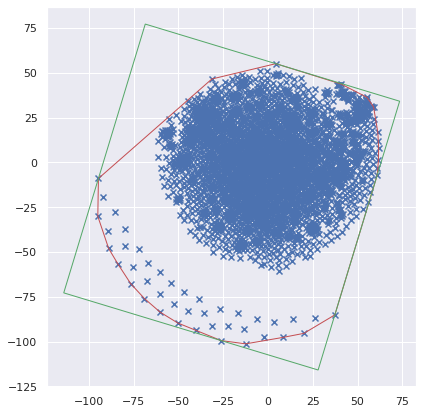

In [32]:
# Instantiate and fit TSNE transformer to training data

all_it = DeepInsightTransformer(feature_extractor='tsne_exact',
                                pixels=RESOLUTION,
                                perplexity=PERPLEXITY,
                                random_state=RAND_SEED,
                                n_jobs=-1)

all_it.fit(train_all_features, plot=True)

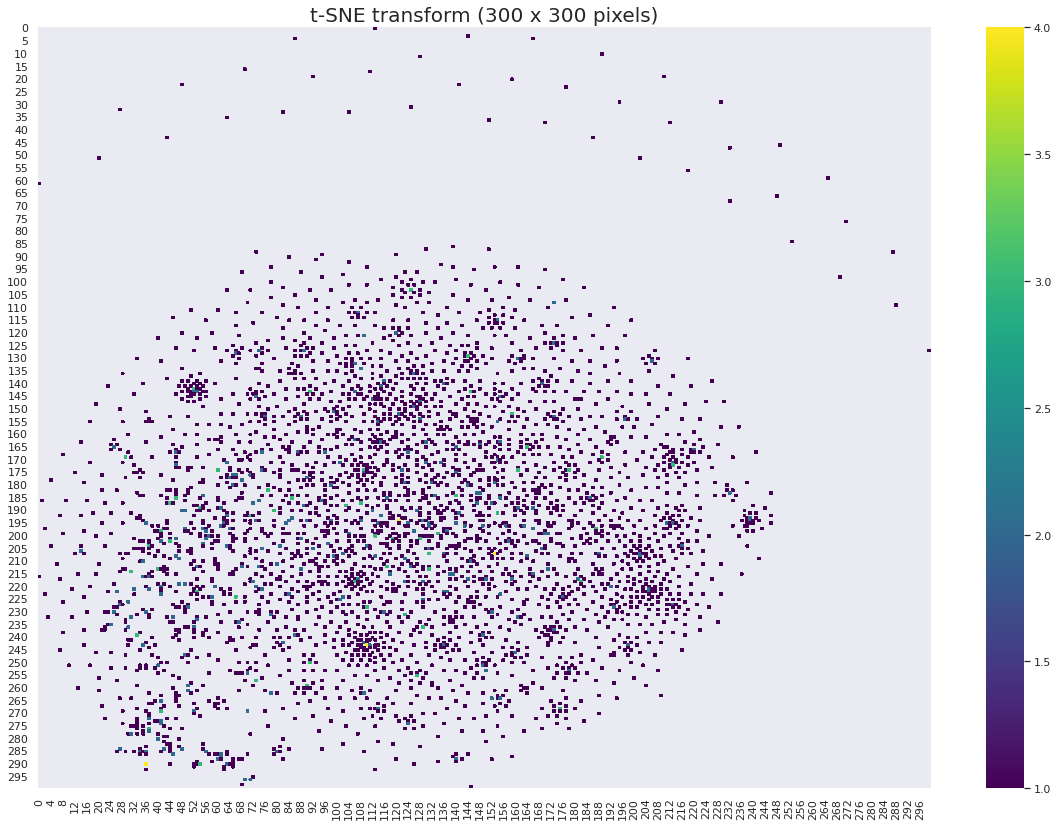

count    3714.000000
mean        1.104470
std         0.359349
min         1.000000
25%         1.000000
50%         1.000000
75%         1.000000
max         4.000000
Name: count, dtype: float64
AxesSubplot(0.125,0.125;0.775x0.755)


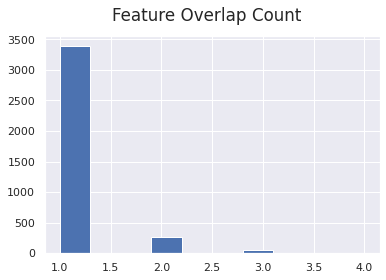

In [33]:
plot_feature_density(all_it, 
                     pixels=RESOLUTION, 
                     show_grid=False, 
                     title='t-SNE transform (300 x 300 pixels)', 
                     save=True, filename_plot='TSNE_transform_300', 
                     filename_hist='feature_overlap_300'
                     )

In [34]:
# copy figures to GCS bucket

#!gsutil -m cp /content/TSNE_transform_300.png gs://{BUCKET_NAME}/capstone_figures/
#!gsutil -m cp /content/feature_overlap_300.png gs://{BUCKET_NAME}/capstone_figures/

In [35]:
# transform datasets with TSNE dimensionality reduction algorithm

train_all_images = all_it.transform(train_all_features, empty_value=1)
valid_all_images = all_it.transform(valid_all_features, empty_value=1)
test_all_images = all_it.transform(test_all_features, empty_value=1)

for df in [train_all_images, valid_all_images, test_all_images]:
  print(len(df), df[0].shape)

13265 (300, 300)
3316 (300, 300)
7107 (300, 300)


In [36]:
# define validation and train labels

y_val = y_train.loc[val_index]
y_train = y_train.loc[train_index]

In [37]:
# convert target dataframes to one-hot encoded label arrays

y_train = y_train.to_numpy(dtype='float32')
y_val = y_val.to_numpy(dtype='float32')
y_test = y_test.to_numpy(dtype='float32') 

type(y_train), y_train.shape, y_val.shape, y_test.shape

(numpy.ndarray, (13265, 185), (3316, 185), (7107, 185))

In [38]:
# Convert list of image arrays to array of arrays
# Expand greyscale image to RGB by adding arbitrary channels (3 channels needed as input for efficientnet)

train_images = np.array(train_all_images, dtype='float32')
train_images = np.expand_dims(train_images, -1)
train_images = train_images.repeat(3, axis=-1)

type(train_images), train_images.shape

(numpy.ndarray, (13265, 300, 300, 3))

In [39]:
val_images = np.array(valid_all_images, dtype='float32')
val_images = np.expand_dims(val_images, -1)
val_images = val_images.repeat(3, axis=-1)

type(val_images), val_images.shape

(numpy.ndarray, (3316, 300, 300, 3))

In [40]:
test_images = np.array(test_all_images, dtype='float32')
test_images = np.expand_dims(test_images, -1)
test_images = test_images.repeat(3, axis=-1)

type(test_images), test_images.shape

(numpy.ndarray, (7107, 300, 300, 3))

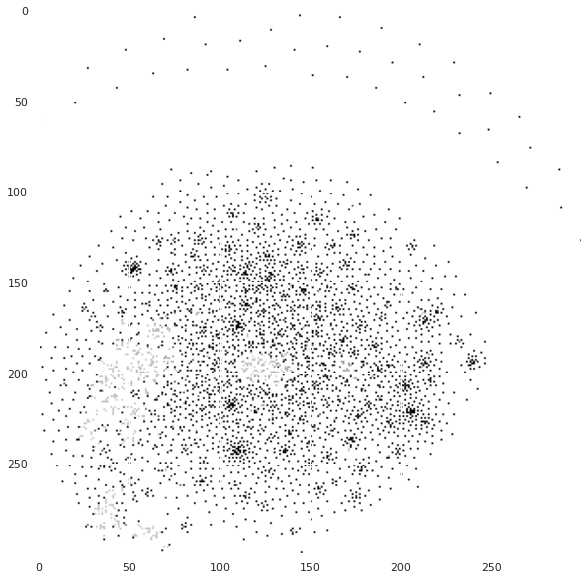

In [41]:
# plot first few images of train

plt.figure(figsize=(10,10))

for i in range(3):

	plt.imshow(val_images[i])
 
# show the figure
plt.show()

# save the figure
#plt.savefig('image_test_300.png', bbox_inches='tight')

# upload figure to GCS bucket
#!gsutil -m cp /content/image_test_300.png gs://{BUCKET_NAME}/capstone_figures/

In [42]:
# Define functions to convert numpy arrays to TFDataset features

def _bytes_feature(value):
    """Returns a bytes_list from a string / byte."""
    if isinstance(value, type(tf.constant(0))): # if value ist tensor
        value = value.numpy() # get value of tensor
    return tf.train.Feature(bytes_list=tf.train.BytesList(value=[value]))

def _float_feature(value):
  """Returns a floast_list from a float / double."""
  return tf.train.Feature(float_list=tf.train.FloatList(value=[value]))

def _int64_feature(value):
  """Returns an int64_list from a bool / enum / int / uint."""
  return tf.train.Feature(int64_list=tf.train.Int64List(value=[value]))

def serialize_array(array):
  array = tf.io.serialize_tensor(array)
  return array

In [43]:
def parse_single_image(image, label):
  
  #define the dictionary -- the structure -- of our single example
  data = {
        'height' : _int64_feature(image.shape[0]),
        'width' : _int64_feature(image.shape[1]),
        'depth' : _int64_feature(image.shape[2]),
        'raw_image' : _bytes_feature(serialize_array(image)),
        'label' : _bytes_feature(serialize_array(label))
    }
  #create an Example, wrapping the single features
  out = tf.train.Example(features=tf.train.Features(feature=data))

  return out

In [44]:
def write_images_to_tfr_short(images, labels, filename:str="images"):
  filename= filename+".tfrecords"
  writer = tf.io.TFRecordWriter(filename) #create a writer that'll store our data to disk
  count = 0

  for index in range(len(images)):

    #get the data we want to write
    current_image = images[index] 
    current_label = labels[index]

    out = parse_single_image(image=current_image, label=current_label)
    writer.write(out.SerializeToString())
    count += 1

  writer.close()
  print(f"Wrote {count} elements to TFRecord")
  return count

In [45]:
def write_images_to_tfr_long(images, labels, filename:str="large_images", max_files:int=BATCH_SIZE, out_dir:str="/content/"):

  #determine the number of shards (single TFRecord files) we need:
  splits = (len(images)//max_files) + 1 #determine how many tfr shards are needed
  if len(images)%max_files == 0:
    splits-=1
  print(f"\nUsing {splits} shard(s) for {len(images)} files, with up to {max_files} samples per shard")

  file_count = 0


  for i in tqdm(range(splits)):
    current_shard_name = "{}{}_{}{}.tfrecords".format(out_dir, i+1, splits, filename)
    writer = tf.io.TFRecordWriter(current_shard_name)

    current_shard_count = 0
    while current_shard_count < max_files: #as long as our shard is not full
      #get the index of the file that we want to parse now
      index = i*max_files+current_shard_count
      if index == len(images): #when we have consumed the whole data, preempt generation
        break

      current_image = images[index]
      current_label = labels[index]

      #create the required Example representation
      out = parse_single_image(image=current_image, label=current_label)
    
      writer.write(out.SerializeToString())
      current_shard_count+=1
      file_count += 1

    writer.close()
  print(f"\nWrote {file_count} elements to TFRecord")
  return file_count        

In [46]:
write_images_to_tfr_long(train_images, y_train, filename='train_ds_256', max_files=BATCH_SIZE)
write_images_to_tfr_long(val_images, y_val, filename='val_ds_256', max_files=256)
write_images_to_tfr_long(test_images, y_test, filename='test_ds_256', max_files=BATCH_SIZE)


Using 52 shard(s) for 13265 files, with up to 256 samples per shard


100%|██████████| 52/52 [00:59<00:00,  1.15s/it]



Wrote 13265 elements to TFRecord

Using 13 shard(s) for 3316 files, with up to 256 samples per shard


100%|██████████| 13/13 [00:14<00:00,  1.09s/it]



Wrote 3316 elements to TFRecord

Using 28 shard(s) for 7107 files, with up to 256 samples per shard


100%|██████████| 28/28 [00:30<00:00,  1.09s/it]


Wrote 7107 elements to TFRecord


7107

In [47]:
# Function to filter tfrecord shards into train, val, test
def Filter(string, substr):
    return [str for str in string if
             any(sub in str for sub in substr)]

In [48]:
dir = os.listdir()

train_files = ['train_ds_256']
val_files = ['val_ds_256']
test_files = ['test_ds_256']

train_filter = Filter(dir, train_files)
val_filter = Filter(dir, val_files)
test_filter = Filter(dir, test_files)

len(train_filter), len(val_filter), len(test_filter)

(52, 13, 28)

In [49]:
# Function to automate upload of TFRecord shards to GCS bucket

def upload_blob(bucket_name=None, source_file_name=None, destination_blob_name=None):
 
    """Uploads a file to GCS bucket."""

    # bucket name = my bucket
    # source_file_name = "/content/data.tfrecords"
    # destination_blob_name = 'path/to/data.tfrecords'
    
    storage_client = storage.Client()
    bucket = storage_client.bucket(bucket_name)
    blob = bucket.blob(destination_blob_name)

    blob.upload_from_filename(source_file_name)

In [50]:
# Upload preprocessed data to GCS bucket

#for count, train_shard in enumerate(train_filter):
#  upload_blob(bucket_name='effnet-moa', source_file_name='/content/'+train_shard, destination_blob_name=DATA_SAVE_PATH + train_shard)

#for count, val_shard in enumerate(val_filter):
#  upload_blob(bucket_name='effnet-moa', source_file_name='/content/'+val_shard, destination_blob_name=DATA_SAVE_PATH + val_shard)

#for count, test_shard in enumerate(test_filter):
#  upload_blob(bucket_name='effnet-moa', source_file_name='/content/'+test_shard, destination_blob_name=DATA_SAVE_PATH + test_shard)